# Linear model on features extracted from power 2011 connectomes

- limit number of features
- use train/val/test


In [1]:
path = ".."

import os
import sys
sys.path.insert(0, path)

import numpy as np
import pandas as pd

import matplotlib
matplotlib.use('Agg')
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns

In [2]:
from problem import get_train_data, get_test_data

data_train_, labels_train_ = get_train_data(path=path)
data_test_, labels_test_ = get_test_data(path=path)

data_train = pd.concat([data_train_, pd.Series(labels_train_, index=data_train_.index, name='target')], axis=1)
data_test = pd.concat([data_test_, pd.Series(labels_test_, index=data_test_.index, name='target')], axis=1)
data = pd.concat([data_train, data_test], axis=0)

accepted_fmri = data['fmri_select'] > 0

In [3]:
data['fmri_select'].value_counts()

1    1029
0     121
Name: fmri_select, dtype: int64

In [4]:
fmri_cols = [c for c in data_train_.columns if "fmri" in c]
fmri_cols

['fmri_basc064',
 'fmri_basc122',
 'fmri_basc197',
 'fmri_craddock_scorr_mean',
 'fmri_harvard_oxford_cort_prob_2mm',
 'fmri_motions',
 'fmri_msdl',
 'fmri_power_2011',
 'fmri_select']

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score


def evaluation_with_fixed_test(X_trainval, y_trainval, X_test, y_test):
            
    train_val_n_splits = 7
    train_val_splt = StratifiedShuffleSplit(n_splits=train_val_n_splits, test_size=0.45, random_state=seed)
    
    results = {}
    validation_roc_folds = []
    test_roc_folds = []

    for train_indices, val_indices in train_val_splt.split(X_trainval, y_trainval):

        train_idx = X_trainval.index[train_indices]
        val_idx = X_trainval.index[val_indices]
        X_train = X_trainval.loc[train_idx, :]
        y_train = y_trainval[train_indices]
        X_valid = X_trainval.loc[val_idx, :]
        y_valid = y_trainval[val_indices]

        pipe = make_pipeline(FeatureExtractor(), Classifier())
        pipe.fit(X_train, y_train)

        y_valid_pred = pipe.predict(X_valid)
        val_roc = roc_auc_score(y_valid, y_valid_pred)
        validation_roc_folds.append(val_roc)

        y_test_pred = pipe.predict(X_test)
        test_roc = roc_auc_score(y_test, y_test_pred)
        test_roc_folds.append(test_roc)

    mean_validation_roc = np.mean(validation_roc_folds)
    mean_test_roc = np.mean(test_roc_folds)

    results['mean_validation_roc'] = mean_validation_roc
    results['mean_test_roc'] = mean_test_roc
    return results


def evaluation_with_test(X, y):
    
    trainval_test_n_splits = 4
    trainval_test_splt = StratifiedKFold(n_splits=trainval_test_n_splits, random_state=seed)
        
    train_val_n_splits = 7
    train_val_splt = StratifiedShuffleSplit(n_splits=train_val_n_splits, test_size=0.45, random_state=seed)
    
    results = {}
    mean_validation_roc_trials = []
    mean_test_roc_trials = []
        
    for i, (trainval_indices, test_indices) in enumerate(trainval_test_splt.split(X, y)):
        
        trainval_idx = X.index[trainval_indices]
        test_idx = X.index[test_indices]
        X_trainval = X.loc[trainval_idx, :]
        y_trainval = y[trainval_indices]

        X_test = X.loc[test_idx, :]
        y_test = y[test_indices]
                
        validation_roc_folds = []
        test_roc_folds = []

        for train_indices, val_indices in train_val_splt.split(X_trainval, y_trainval):

            train_idx = X_trainval.index[train_indices]
            val_idx = X_trainval.index[val_indices]
            
            X_train = X_trainval.loc[train_idx, :]
            y_train = y_trainval[train_indices]
            X_valid = X_trainval.loc[val_idx, :]
            y_valid = y_trainval[val_indices]

            pipe = make_pipeline(FeatureExtractor(), Classifier())
            pipe.fit(X_train, y_train)

            y_valid_pred = pipe.predict(X_valid)
            val_roc = roc_auc_score(y_valid, y_valid_pred)
            validation_roc_folds.append(val_roc)

            y_test_probas = pipe.predict_proba(X_test)[:, 1]
            y_test_pred = (y_test_probas > 0.5).astype(np.uint8)
            test_roc = roc_auc_score(y_test, y_test_pred)
            test_roc_folds.append(test_roc)

        mean_validation_roc = np.mean(validation_roc_folds)
        mean_test_roc = np.mean(test_roc_folds)

        results['trial_{}__mean_validation_roc'.format(i)] = mean_validation_roc
        results['trial_{}__mean_test_roc'.format(i)] = mean_test_roc
    
        mean_validation_roc_trials.append(mean_validation_roc)
        mean_test_roc_trials.append(mean_test_roc)
        
    results['avg_mean_validation_roc'] = np.mean(mean_validation_roc_trials)
    results['avg_mean_test_roc'] = np.mean(mean_test_roc_trials)
    results['std_mean_validation_roc'] = np.std(mean_validation_roc_trials)
    results['std_mean_test_roc'] = np.std(mean_test_roc_trials)
    return results



from problem import get_cv


def original_evaluation(X, y, verbose=False):
    pipe = make_pipeline(FeatureExtractor(), Classifier())
    cv = get_cv(X, y)
    results = cross_validate(pipe, X, y, scoring=['roc_auc', 'accuracy'], cv=cv,
                             verbose=verbose, return_train_score=True,
                             n_jobs=1)    
    return results

### Atlas Power 2011

In [6]:
from nilearn import datasets
atlas = datasets.fetch_coords_power_2011()

In [7]:
from nilearn.signal import clean
from nilearn.connectome import ConnectivityMeasure

data1 = data.loc[accepted_fmri, :].copy()
print(data1.shape)
correlation_measure = ConnectivityMeasure(kind='covariance', discard_diagonal=True, vectorize=True)

(1029, 222)


In [8]:
x_trainval_test = np.zeros((len(data1), 34716))

ll = len(data1.index)
for i, idx in enumerate(data1.index):
    if i % 100 == 0:
        print("-- {}/{}".format(i, ll))
    path_motions = os.path.join(path, data1.loc[idx, 'fmri_motions'])
    confounds = np.loadtxt(path_motions)
    path_fmri_atlas = os.path.join(path, data1.loc[idx, 'fmri_power_2011'])
    timeseries = pd.read_csv(path_fmri_atlas, header=None).values
    cleaned_timeseries = clean(timeseries, confounds=confounds)
    correlation_matrix = correlation_measure.fit_transform([cleaned_timeseries])[0]
    x_trainval_test[i, :] = correlation_matrix
    

-- 0/1029
-- 100/1029
-- 200/1029
-- 300/1029
-- 400/1029
-- 500/1029
-- 600/1029
-- 700/1029
-- 800/1029
-- 900/1029
-- 1000/1029


In [9]:
data2 = data1[['participants_sex', 'participants_age', 'target']].copy()
data2['participants_sex'] = data2['participants_sex'].map({'F': -1.0, 'M': +1.0})

power_features = ["power_{}".format(i) for i in range(x_trainval_test.shape[1])]
data2 = pd.concat([data2, pd.DataFrame(x_trainval_test, index=data2.index, columns=power_features)], axis=1)

In [10]:
seed = 20
trainval_test_n_splits = 4
trainval_test_splt = StratifiedKFold(n_splits=trainval_test_n_splits, random_state=seed)

trainval_indices, test_indices = next(trainval_test_splt.split(data2['participants_age'], data2['target']))
trainval_idx = data2.index[trainval_indices]
test_idx = data2.index[test_indices]

data2_trainval = data2.loc[trainval_idx, :]
data2_test = data2.loc[test_idx, :]
data2_trainval.shape, data2_test.shape

((771, 34719), (258, 34719))

With PCA

In [125]:
from itertools import product

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA


seed = 90
       

class FeatureExtractor(BaseEstimator, TransformerMixin):
        
    def __init__(self):
        self.pca = None
        
    def fit(self, X_df, y):        
        self.pca = PCA(n_components=160)
        self.pca.fit(X_df)
        return self

    def transform(self, X_df):
        assert self.pca is not None        
        return self.pca.transform(X_df)


class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(
                                StandardScaler(),
                                LogisticRegressionCV(n_jobs=4,
                                                     # cv=StratifiedKFold(n_splits=5, random_state=seed),                                                    
                                                     scoring="roc_auc", 
                                                     random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(
                                 StandardScaler(),
                                 LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

In [126]:
cols = power_features

In [127]:
results = evaluation_with_test(data2.loc[:, cols], 
                               data2.loc[:, 'target'].values)
print(results['avg_mean_validation_roc'], results['avg_mean_test_roc'])        

0.6374860967570447 0.6512572843457936


In [128]:
results

{'trial_0__mean_validation_roc': 0.6322614601989104,
 'trial_0__mean_test_roc': 0.651768494282959,
 'trial_1__mean_validation_roc': 0.6330953643387366,
 'trial_1__mean_test_roc': 0.6580882352941176,
 'trial_2__mean_validation_roc': 0.6314478866838359,
 'trial_2__mean_test_roc': 0.6520287867213,
 'trial_3__mean_validation_roc': 0.653139675806696,
 'trial_3__mean_test_roc': 0.6431436210847975,
 'avg_mean_validation_roc': 0.6374860967570447,
 'avg_mean_test_roc': 0.6512572843457936,
 'std_mean_validation_roc': 0.009056349654878292,
 'std_mean_test_roc': 0.005323297236828781}

150
```
0.6405595208664239 0.6502155097576221
```

160
```
0.6374860967570447 0.6512572843457936
```

170
```
0.6436035672230365 0.6448657458851309
```

250
```
0.6409835886550003 0.6463006453089297
```

Select features by correlation

In [93]:
cols = power_features

In [94]:
corr = data2_trainval[cols].corrwith(data2_trainval['target'])

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


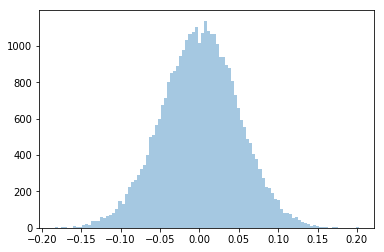

In [95]:
sns.distplot(corr, kde=False, bins=100)

In [96]:
corr1 = corr[corr.abs() > 0.1].abs().sort_values()
cols1 = corr1.index.values.tolist()
len(cols1)

1467

In [97]:
selected_cols = []

In [98]:
for index, c in enumerate(cols1):
    _cols = list(cols1)
    _cols.remove(c)
    col_corr = data2_trainval[_cols].corrwith(data2_trainval[c])

    corr_cols = col_corr[col_corr.abs() > 0.5].index.values.tolist()
    corr_cols += [c, ]
    selected_cols.append(corr1[corr_cols].idxmax())
selected_cols = list(set(selected_cols))    

In [99]:
len(selected_cols), len(cols1)

(687, 1467)

In [100]:
from itertools import product

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA


seed = 90
       

class FeatureExtractor(BaseEstimator, TransformerMixin):
                
    def fit(self, X_df, y):        
        return self

    def transform(self, X_df):
        return X_df


class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(
                                StandardScaler(),
                                LogisticRegressionCV(n_jobs=4,
                                                     # cv=StratifiedKFold(n_splits=5, random_state=seed),                                                    
                                                     scoring="roc_auc", 
                                                     random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(
                                 StandardScaler(),
                                 LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

In [101]:
results = evaluation_with_test(data2.loc[:, selected_cols], 
                               data2.loc[:, 'target'].values)
print(results['avg_mean_validation_roc'], results['avg_mean_test_roc'])

0.7395239340246831 0.7411346338088141


In [102]:
results

{'trial_0__mean_validation_roc': 0.7674522729870823,
 'trial_0__mean_test_roc': 0.6705641272902604,
 'trial_1__mean_validation_roc': 0.7172208756249053,
 'trial_1__mean_test_roc': 0.7750668449197861,
 'trial_2__mean_validation_roc': 0.7197867747311013,
 'trial_2__mean_test_roc': 0.7785219459684699,
 'trial_3__mean_validation_roc': 0.7536358127556431,
 'trial_3__mean_test_roc': 0.74038561705674,
 'avg_mean_validation_roc': 0.7395239340246831,
 'avg_mean_test_roc': 0.7411346338088141,
 'std_mean_validation_roc': 0.02159930039075401,
 'std_mean_test_roc': 0.04338768107937792}

Power with age

In [76]:
data_ = np.zeros((len(x_trainval_test), len(power_features) * 2))
new_columns = []

for i, name in enumerate(power_features):
    new_col = "{} x participants_age".format(name)
    new_columns.append(new_col)
    data_[:, 2*i] = data2[name] * data2['participants_age']
    new_col = "{} / participants_age".format(name)
    new_columns.append(new_col)
    data_[:, 2*i + 1] = data2[name] / data2['participants_age']
    

pairs_df = pd.DataFrame(data_, columns=new_columns, index=data2.index)
data3 = pd.concat([data2, pairs_df], axis=1)

In [78]:
data3.shape, len(new_columns)

((1029, 104151), 69432)

In [104]:
cols = new_columns

data3_trainval = data3.loc[trainval_idx, :]
data3_test = data3.loc[test_idx, :]
data3_trainval.shape, data3_test.shape

((771, 104151), (258, 104151))

In [105]:
corr = data3_trainval[cols].corrwith(data3_trainval['target'])

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


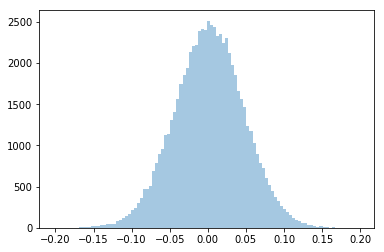

In [106]:
sns.distplot(corr, kde=False, bins=100)

In [111]:
corr1 = corr[corr.abs() > 0.088].abs().sort_values()
cols1 = corr1.index.values.tolist()
len(cols1)

3706

In [112]:
selected_cols = []

In [113]:
for index, c in enumerate(cols1):
    _cols = list(cols1)
    _cols.remove(c)
    col_corr = data3_trainval[_cols].corrwith(data3_trainval[c])

    corr_cols = col_corr[col_corr.abs() > 0.5].index.values.tolist()
    corr_cols += [c, ]
    selected_cols.append(corr1[corr_cols].idxmax())
selected_cols = list(set(selected_cols))    

In [114]:
len(selected_cols), len(cols1)

(1574, 3706)

In [115]:
from itertools import product

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA


seed = 90
       

class FeatureExtractor(BaseEstimator, TransformerMixin):
                
    def fit(self, X_df, y):        
        return self

    def transform(self, X_df):
        return X_df


class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(
                                StandardScaler(),
                                LogisticRegressionCV(n_jobs=4,
                                                     # cv=StratifiedKFold(n_splits=5, random_state=seed),                                                    
                                                     scoring="roc_auc", 
                                                     random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(
                                 StandardScaler(),
                                 LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

In [116]:
results = evaluation_with_test(data3.loc[:, selected_cols], 
                               data3.loc[:, 'target'].values)
print(results['avg_mean_validation_roc'], results['avg_mean_test_roc'])

0.7690984872388735 0.7696984912715934


In [117]:
results

{'trial_0__mean_validation_roc': 0.7980175665891859,
 'trial_0__mean_test_roc': 0.6970226615236258,
 'trial_1__mean_validation_roc': 0.7573568398727465,
 'trial_1__mean_test_roc': 0.7945473644003055,
 'trial_2__mean_validation_roc': 0.7548288138160884,
 'trial_2__mean_test_roc': 0.7976942843253003,
 'trial_3__mean_validation_roc': 0.7661907286774732,
 'trial_3__mean_test_roc': 0.7895296548371415,
 'avg_mean_validation_roc': 0.7690984872388735,
 'avg_mean_test_roc': 0.7696984912715934,
 'std_mean_validation_roc': 0.017221048696177587,
 'std_mean_test_roc': 0.04206032038154225}

compare with LR selected features

In [91]:
f2_columns = ["power_37 / participants_age", "power_46 / participants_age", "power_62 / participants_age", "power_64 / participants_age", "power_166 x participants_age", "power_180 / participants_age", "power_255 / participants_age", "power_262 x participants_age", "power_328 / participants_age", "power_343 / participants_age", "power_409 x participants_age", "power_436 / participants_age", "power_451 / participants_age", "power_499 / participants_age", "power_505 x participants_age", "power_561 / participants_age", "power_633 / participants_age", "power_648 / participants_age", "power_729 x participants_age", "power_729 / participants_age", "power_737 / participants_age", "power_739 x participants_age", "power_739 / participants_age", "power_789 / participants_age", "power_863 x participants_age", "power_888 / participants_age", "power_1028 / participants_age", "power_1075 / participants_age", "power_1145 / participants_age", "power_1156 / participants_age", "power_1193 / participants_age", "power_1204 / participants_age", "power_1231 x participants_age", "power_1231 / participants_age", "power_1253 / participants_age", "power_1265 / participants_age", "power_1302 / participants_age", "power_1349 / participants_age", "power_1354 / participants_age", "power_1366 / participants_age", "power_1370 / participants_age", "power_1431 x participants_age", "power_1512 / participants_age", "power_1534 x participants_age", "power_1567 / participants_age", "power_1738 / participants_age", "power_1829 / participants_age", "power_1847 / participants_age", "power_1857 / participants_age", "power_2347 / participants_age", "power_2373 / participants_age", "power_2442 / participants_age", "power_2726 x participants_age", "power_2735 x participants_age", "power_2840 x participants_age", "power_2840 / participants_age", "power_2856 x participants_age", "power_2875 / participants_age", "power_2897 / participants_age", "power_2910 x participants_age", "power_2923 x participants_age", "power_2945 x participants_age", "power_2945 / participants_age", "power_2946 / participants_age", "power_2951 x participants_age", "power_2951 / participants_age", "power_2955 / participants_age", "power_2956 / participants_age", "power_2958 x participants_age", "power_2958 / participants_age", "power_2961 / participants_age", "power_2962 x participants_age", "power_2970 / participants_age", "power_2974 / participants_age", "power_2995 / participants_age", "power_3028 / participants_age", "power_3098 / participants_age", "power_3142 / participants_age", "power_3143 / participants_age", "power_3297 / participants_age", "power_3316 / participants_age", "power_3318 / participants_age", "power_3576 / participants_age", "power_3594 / participants_age", "power_3632 / participants_age", "power_3633 / participants_age", "power_3640 / participants_age", "power_3679 / participants_age", "power_3684 / participants_age", "power_3687 / participants_age", "power_3730 / participants_age", "power_3822 / participants_age", "power_3853 x participants_age", "power_3880 x participants_age", "power_3925 x participants_age", "power_3940 / participants_age", "power_4014 x participants_age", "power_4336 / participants_age", "power_4380 x participants_age", "power_4395 / participants_age", "power_4402 / participants_age", "power_4447 x participants_age", "power_4478 / participants_age", "power_4528 / participants_age", "power_4618 / participants_age", "power_4637 / participants_age", "power_4712 / participants_age", "power_4713 / participants_age", "power_4740 / participants_age", "power_4796 / participants_age", "power_4853 / participants_age", "power_4858 / participants_age", "power_4862 / participants_age", "power_4867 / participants_age", "power_5034 / participants_age", "power_5067 / participants_age", "power_5106 / participants_age", "power_5121 / participants_age", "power_5207 / participants_age", "power_5249 / participants_age", "power_5320 / participants_age", "power_5558 / participants_age", "power_5569 / participants_age", "power_5675 / participants_age", "power_5690 x participants_age", "power_5690 / participants_age", "power_5696 x participants_age", "power_5696 / participants_age", "power_5703 x participants_age", "power_5703 / participants_age", "power_5768 / participants_age", "power_5782 / participants_age", "power_5894 / participants_age", "power_5911 / participants_age", "power_5917 / participants_age", "power_5933 / participants_age", "power_5946 x participants_age", "power_5946 / participants_age", "power_5999 / participants_age", "power_6076 / participants_age", "power_6112 x participants_age", "power_6112 / participants_age", "power_6184 x participants_age", "power_6186 / participants_age", "power_6207 / participants_age", "power_6297 / participants_age", "power_6318 / participants_age", "power_6559 / participants_age", "power_6630 / participants_age", "power_6658 / participants_age", "power_6661 x participants_age", "power_6661 / participants_age", "power_6663 / participants_age", "power_6664 x participants_age", "power_6664 / participants_age", "power_6693 / participants_age", "power_6710 x participants_age", "power_6710 / participants_age", "power_6812 / participants_age", "power_6816 / participants_age", "power_6825 / participants_age", "power_6867 / participants_age", "power_6878 x participants_age", "power_6915 / participants_age", "power_7066 x participants_age", "power_7196 / participants_age", "power_7205 / participants_age", "power_7257 / participants_age", "power_7285 / participants_age", "power_7320 x participants_age", "power_7320 / participants_age", "power_7332 x participants_age", "power_7332 / participants_age", "power_7382 / participants_age", "power_7391 / participants_age", "power_7419 / participants_age", "power_7453 / participants_age", "power_7474 x participants_age", "power_7474 / participants_age", "power_7479 x participants_age", "power_7487 x participants_age", "power_7500 x participants_age", "power_7529 / participants_age", "power_7609 x participants_age", "power_7628 x participants_age", "power_7702 x participants_age", "power_7714 / participants_age", "power_7752 x participants_age", "power_7752 / participants_age", "power_7917 / participants_age", "power_7938 / participants_age", "power_7961 / participants_age", "power_7967 / participants_age", "power_7969 / participants_age", "power_7981 / participants_age", "power_7994 / participants_age", "power_7999 x participants_age", "power_8099 / participants_age", "power_8104 x participants_age", "power_8112 / participants_age", "power_8205 / participants_age", "power_8275 / participants_age", "power_8288 / participants_age", "power_8321 / participants_age", "power_8349 / participants_age", "power_8415 / participants_age", "power_8451 x participants_age", "power_8451 / participants_age", "power_8453 / participants_age", "power_8462 / participants_age", "power_8465 x participants_age", "power_8477 x participants_age", "power_8483 / participants_age", "power_8590 / participants_age", "power_8596 x participants_age", "power_8596 / participants_age", "power_8611 / participants_age", "power_8619 / participants_age", "power_8620 / participants_age", "power_8631 / participants_age", "power_8642 x participants_age", "power_8642 / participants_age", "power_8704 / participants_age", "power_8705 / participants_age", "power_8768 x participants_age", "power_8772 / participants_age", "power_9037 x participants_age", "power_9037 / participants_age", "power_9291 x participants_age", "power_9291 / participants_age", "power_9332 x participants_age", "power_9333 / participants_age", "power_9347 / participants_age", "power_9429 / participants_age", "power_9471 / participants_age", "power_9539 / participants_age", "power_9548 / participants_age", "power_9550 / participants_age", "power_9552 / participants_age", "power_9556 / participants_age", "power_9564 / participants_age", "power_9570 x participants_age", "power_9570 / participants_age", "power_9580 / participants_age", "power_9711 / participants_age", "power_9791 / participants_age", "power_10222 / participants_age", "power_10251 / participants_age", "power_10375 / participants_age", "power_10463 / participants_age", "power_10654 / participants_age", "power_10667 x participants_age", "power_10880 / participants_age", "power_11208 x participants_age", "power_11382 / participants_age", "power_11438 x participants_age", "power_11478 / participants_age", "power_11617 / participants_age", "power_11630 / participants_age", "power_11649 / participants_age", "power_11654 / participants_age", "power_11664 / participants_age", "power_11705 / participants_age", "power_11710 / participants_age", "power_11720 x participants_age", "power_11720 / participants_age", "power_11736 / participants_age", "power_11783 x participants_age", "power_11783 / participants_age", "power_11797 / participants_age", "power_11937 / participants_age", "power_11938 / participants_age", "power_12111 / participants_age", "power_12151 / participants_age", "power_12161 / participants_age", "power_12251 / participants_age", "power_12276 / participants_age", "power_12472 / participants_age", "power_12579 x participants_age", "power_12583 x participants_age", "power_12583 / participants_age", "power_12584 / participants_age", "power_12587 / participants_age", "power_12597 / participants_age", "power_12621 x participants_age", "power_12721 / participants_age", "power_12794 x participants_age", "power_12805 x participants_age", "power_12806 x participants_age", "power_12806 / participants_age", "power_12883 / participants_age", "power_12895 / participants_age", "power_13073 x participants_age", "power_13158 x participants_age", "power_13169 x participants_age", "power_13194 x participants_age", "power_13194 / participants_age", "power_13206 / participants_age", "power_13280 / participants_age", "power_13295 / participants_age", "power_13365 / participants_age", "power_13368 / participants_age", "power_13409 / participants_age", "power_13427 / participants_age", "power_13446 x participants_age", "power_13446 / participants_age", "power_13621 x participants_age", "power_13621 / participants_age", "power_13718 / participants_age", "power_13797 x participants_age", "power_13797 / participants_age", "power_13864 / participants_age", "power_13882 / participants_age", "power_14097 / participants_age", "power_14169 / participants_age", "power_14201 / participants_age", "power_14370 / participants_age", "power_14557 / participants_age", "power_14707 / participants_age", "power_14775 / participants_age", "power_14787 x participants_age", "power_14904 / participants_age", "power_15182 / participants_age", "power_15193 / participants_age", "power_15195 / participants_age", "power_15196 / participants_age", "power_15198 / participants_age", "power_15217 / participants_age", "power_15220 / participants_age", "power_15287 x participants_age", "power_15291 x participants_age", "power_15343 / participants_age", "power_15366 / participants_age", "power_15411 / participants_age", "power_15502 / participants_age", "power_15505 x participants_age", "power_15505 / participants_age", "power_15518 / participants_age", "power_15538 / participants_age", "power_15712 / participants_age", "power_15749 / participants_age", "power_15814 x participants_age", "power_15814 / participants_age", "power_15892 / participants_age", "power_16017 x participants_age", "power_16050 x participants_age", "power_16187 / participants_age", "power_16258 / participants_age", "power_16264 / participants_age", "power_16372 / participants_age", "power_16409 / participants_age", "power_16529 x participants_age", "power_16529 / participants_age", "power_16530 / participants_age", "power_16551 / participants_age", "power_16647 / participants_age", "power_16663 / participants_age", "power_16732 x participants_age", "power_16741 / participants_age", "power_16745 / participants_age", "power_16747 / participants_age", "power_16785 / participants_age", "power_16786 x participants_age", "power_16786 / participants_age", "power_16787 x participants_age", "power_16787 / participants_age", "power_16830 / participants_age", "power_16878 / participants_age", "power_16906 / participants_age", "power_16909 x participants_age", "power_16909 / participants_age", "power_16915 x participants_age", "power_16921 / participants_age", "power_16922 / participants_age", "power_16928 x participants_age", "power_16930 / participants_age", "power_16955 / participants_age", "power_16960 x participants_age", "power_17038 / participants_age", "power_17079 x participants_age", "power_17151 / participants_age", "power_17240 x participants_age", "power_17323 / participants_age", "power_17389 x participants_age", "power_17389 / participants_age", "power_17394 x participants_age", "power_17394 / participants_age", "power_17426 / participants_age", "power_17451 x participants_age", "power_17451 / participants_age", "power_17457 x participants_age", "power_17493 / participants_age", "power_17578 / participants_age", "power_17581 x participants_age", "power_17581 / participants_age", "power_17596 / participants_age", "power_17627 / participants_age", "power_17719 / participants_age", "power_17760 / participants_age", "power_17977 x participants_age", "power_17990 x participants_age", "power_17990 / participants_age", "power_18053 x participants_age", "power_18111 x participants_age", "power_18116 x participants_age", "power_18129 / participants_age", "power_18139 x participants_age", "power_18139 / participants_age", "power_18328 x participants_age", "power_18329 x participants_age", "power_18329 / participants_age", "power_18394 / participants_age", "power_18398 x participants_age", "power_18398 / participants_age", "power_18446 / participants_age", "power_18450 / participants_age", "power_18711 x participants_age", "power_18712 x participants_age", "power_18712 / participants_age", "power_18755 x participants_age", "power_18762 / participants_age", "power_18764 / participants_age", "power_18766 / participants_age", "power_18791 x participants_age", "power_18791 / participants_age", "power_18816 / participants_age", "power_18822 / participants_age", "power_18823 / participants_age", "power_18839 / participants_age", "power_18840 / participants_age", "power_18850 x participants_age", "power_18850 / participants_age", "power_18904 x participants_age", "power_18904 / participants_age", "power_18905 / participants_age", "power_19021 / participants_age", "power_19025 x participants_age", "power_19025 / participants_age", "power_19027 / participants_age", "power_19287 / participants_age", "power_19342 x participants_age", "power_19366 x participants_age", "power_19450 / participants_age", "power_19451 x participants_age", "power_19483 / participants_age", "power_19491 / participants_age", "power_19525 / participants_age", "power_19526 / participants_age", "power_19564 / participants_age", "power_19573 / participants_age", "power_19620 x participants_age", "power_19677 / participants_age", "power_19735 x participants_age", "power_19750 x participants_age", "power_19761 x participants_age", "power_19769 x participants_age", "power_19771 x participants_age", "power_20002 / participants_age", "power_20016 / participants_age", "power_20036 / participants_age", "power_20111 / participants_age", "power_20201 / participants_age", "power_20202 / participants_age", "power_20215 / participants_age", "power_20218 / participants_age", "power_20230 / participants_age", "power_20236 / participants_age", "power_20238 / participants_age", "power_20286 / participants_age", "power_20430 / participants_age", "power_20475 / participants_age", "power_20606 / participants_age", "power_20686 x participants_age", "power_20762 / participants_age", "power_20790 / participants_age", "power_20811 / participants_age", "power_20882 / participants_age", "power_20935 / participants_age", "power_21264 x participants_age", "power_21381 / participants_age", "power_21600 x participants_age", "power_21607 / participants_age", "power_21625 / participants_age", "power_21630 / participants_age", "power_21633 / participants_age", "power_21796 / participants_age", "power_21802 / participants_age", "power_21808 x participants_age", "power_21833 / participants_age", "power_21853 x participants_age", "power_21853 / participants_age", "power_21855 x participants_age", "power_21855 / participants_age", "power_21875 x participants_age", "power_21875 / participants_age", "power_21893 x participants_age", "power_21914 x participants_age", "power_21972 / participants_age", "power_22017 x participants_age", "power_22025 x participants_age", "power_22093 / participants_age", "power_22161 x participants_age", "power_22251 / participants_age", "power_22257 / participants_age", "power_22311 / participants_age", "power_22346 / participants_age", "power_22348 / participants_age", "power_22350 / participants_age", "power_22353 x participants_age", "power_22353 / participants_age", "power_22563 / participants_age", "power_22657 x participants_age", "power_22659 x participants_age", "power_22659 / participants_age", "power_22675 / participants_age", "power_22680 / participants_age", "power_22693 x participants_age", "power_22694 x participants_age", "power_22705 / participants_age", "power_22870 / participants_age", "power_22982 x participants_age", "power_22982 / participants_age", "power_22989 / participants_age", "power_23183 / participants_age", "power_23226 x participants_age", "power_23363 / participants_age", "power_23376 / participants_age", "power_23402 x participants_age", "power_23402 / participants_age", "power_23411 x participants_age", "power_23411 / participants_age", "power_23418 / participants_age", "power_23439 x participants_age", "power_23439 / participants_age", "power_23448 / participants_age", "power_23582 / participants_age", "power_23601 / participants_age", "power_23638 / participants_age", "power_23700 / participants_age", "power_23746 / participants_age", "power_23786 / participants_age", "power_23831 x participants_age", "power_23857 / participants_age", "power_24012 / participants_age", "power_24053 / participants_age", "power_24145 / participants_age", "power_24148 / participants_age", "power_24149 / participants_age", "power_24171 x participants_age", "power_24171 / participants_age", "power_24194 / participants_age", "power_24195 x participants_age", "power_24195 / participants_age", "power_24205 x participants_age", "power_24216 / participants_age", "power_24295 / participants_age", "power_24296 / participants_age", "power_24304 / participants_age", "power_24308 / participants_age", "power_24316 x participants_age", "power_24337 x participants_age", "power_24337 / participants_age", "power_24341 x participants_age", "power_24493 / participants_age", "power_24612 / participants_age", "power_24651 / participants_age", "power_24779 / participants_age", "power_24780 / participants_age", "power_24828 x participants_age", "power_24876 x participants_age", "power_24898 / participants_age", "power_24922 / participants_age", "power_24982 x participants_age", "power_25002 / participants_age", "power_25003 / participants_age", "power_25145 / participants_age", "power_25163 / participants_age", "power_25320 x participants_age", "power_25383 / participants_age", "power_25391 / participants_age", "power_25396 x participants_age", "power_25400 / participants_age", "power_25429 / participants_age", "power_25451 / participants_age", "power_25452 / participants_age", "power_25606 / participants_age", "power_25678 x participants_age", "power_25678 / participants_age", "power_25691 / participants_age", "power_25781 x participants_age", "power_25781 / participants_age", "power_25826 / participants_age", "power_25838 / participants_age", "power_25905 / participants_age", "power_26062 x participants_age", "power_26062 / participants_age", "power_26066 x participants_age", "power_26066 / participants_age", "power_26077 x participants_age", "power_26085 x participants_age", "power_26085 / participants_age", "power_26112 x participants_age", "power_26112 / participants_age", "power_26133 / participants_age", "power_26182 x participants_age", "power_26362 / participants_age", "power_26547 x participants_age", "power_26592 / participants_age", "power_26762 / participants_age", "power_26769 / participants_age", "power_26773 x participants_age", "power_26777 / participants_age", "power_26814 / participants_age", "power_26823 / participants_age", "power_26824 / participants_age", "power_26827 / participants_age", "power_26836 / participants_age", "power_26965 / participants_age", "power_26983 / participants_age", "power_26990 / participants_age", "power_27014 / participants_age", "power_27055 / participants_age", "power_27198 / participants_age", "power_27200 / participants_age", "power_27215 / participants_age", "power_27222 / participants_age", "power_27276 x participants_age", "power_27278 / participants_age", "power_27280 x participants_age", "power_27293 x participants_age", "power_27307 x participants_age", "power_27312 x participants_age", "power_27314 x participants_age", "power_27354 / participants_age", "power_27374 / participants_age", "power_27393 / participants_age", "power_27396 / participants_age", "power_27463 x participants_age", "power_27463 / participants_age", "power_27481 / participants_age", "power_27512 / participants_age", "power_27516 / participants_age", "power_27525 / participants_age", "power_27529 / participants_age", "power_27534 / participants_age", "power_27572 x participants_age", "power_27658 / participants_age", "power_27699 / participants_age", "power_27704 x participants_age", "power_27704 / participants_age", "power_27751 / participants_age", "power_27760 / participants_age", "power_27764 / participants_age", "power_27767 / participants_age", "power_27810 x participants_age", "power_27983 / participants_age", "power_27993 / participants_age", "power_27994 x participants_age", "power_28006 / participants_age", "power_28009 / participants_age", "power_28035 / participants_age", "power_28046 x participants_age", "power_28046 / participants_age", "power_28109 / participants_age", "power_28113 / participants_age", "power_28123 / participants_age", "power_28124 / participants_age", "power_28129 / participants_age", "power_28132 / participants_age", "power_28138 / participants_age", "power_28259 / participants_age", "power_28283 x participants_age", "power_28283 / participants_age", "power_28300 / participants_age", "power_28320 / participants_age", "power_28334 x participants_age", "power_28334 / participants_age", "power_28458 / participants_age", "power_28521 x participants_age", "power_28523 x participants_age", "power_28524 x participants_age", "power_28526 / participants_age", "power_28538 x participants_age", "power_28554 / participants_age", "power_28560 x participants_age", "power_28560 / participants_age", "power_28572 x participants_age", "power_28740 x participants_age", "power_28740 / participants_age", "power_28744 x participants_age", "power_28744 / participants_age", "power_28811 x participants_age", "power_28811 / participants_age", "power_28819 / participants_age", "power_28829 / participants_age", "power_28906 / participants_age", "power_28908 / participants_age", "power_29017 / participants_age", "power_29031 / participants_age", "power_29038 / participants_age", "power_29040 / participants_age", "power_29051 / participants_age", "power_29064 / participants_age", "power_29071 / participants_age", "power_29166 / participants_age", "power_29203 / participants_age", "power_29222 x participants_age", "power_29222 / participants_age", "power_29241 / participants_age", "power_29459 / participants_age", "power_29593 x participants_age", "power_29630 x participants_age", "power_29630 / participants_age", "power_29633 x participants_age", "power_29640 / participants_age", "power_29648 / participants_age", "power_29867 / participants_age", "power_29880 / participants_age", "power_29895 / participants_age", "power_29951 x participants_age", "power_29951 / participants_age", "power_29982 x participants_age", "power_30023 x participants_age", "power_30023 / participants_age", "power_30024 x participants_age", "power_30025 x participants_age", "power_30025 / participants_age", "power_30084 x participants_age", "power_30089 x participants_age", "power_30105 x participants_age", "power_30106 x participants_age", "power_30111 / participants_age", "power_30115 / participants_age", "power_30118 / participants_age", "power_30135 x participants_age", "power_30214 x participants_age", "power_30217 / participants_age", "power_30218 / participants_age", "power_30235 x participants_age", "power_30270 x participants_age", "power_30270 / participants_age", "power_30276 x participants_age", "power_30276 / participants_age", "power_30313 x participants_age", "power_30441 x participants_age", "power_30464 / participants_age", "power_30477 x participants_age", "power_30485 / participants_age", "power_30555 x participants_age", "power_30568 / participants_age", "power_30599 x participants_age", "power_30640 / participants_age", "power_30644 x participants_age", "power_30644 / participants_age", "power_30645 x participants_age", "power_30645 / participants_age", "power_30666 x participants_age", "power_30666 / participants_age", "power_30667 x participants_age", "power_30667 / participants_age", "power_30701 / participants_age", "power_30705 / participants_age", "power_30707 x participants_age", "power_30717 x participants_age", "power_30717 / participants_age", "power_30720 x participants_age", "power_30720 / participants_age", "power_30721 x participants_age", "power_30721 / participants_age", "power_30722 / participants_age", "power_30723 / participants_age", "power_30724 x participants_age", "power_30731 x participants_age", "power_30731 / participants_age", "power_30738 / participants_age", "power_30739 / participants_age", "power_30740 / participants_age", "power_30744 / participants_age", "power_30757 / participants_age", "power_30760 x participants_age", "power_30760 / participants_age", "power_30761 x participants_age", "power_30763 / participants_age", "power_30786 / participants_age", "power_30790 / participants_age", "power_30831 / participants_age", "power_30848 x participants_age", "power_30848 / participants_age", "power_30938 / participants_age", "power_30961 / participants_age", "power_30986 / participants_age", "power_30988 / participants_age", "power_31038 x participants_age", "power_31069 x participants_age", "power_31299 / participants_age", "power_31306 / participants_age", "power_31308 x participants_age", "power_31308 / participants_age", "power_31316 / participants_age", "power_31318 / participants_age", "power_31365 x participants_age", "power_31439 / participants_age", "power_31441 / participants_age", "power_31444 / participants_age", "power_31452 x participants_age", "power_31452 / participants_age", "power_31540 / participants_age", "power_31579 / participants_age", "power_31678 x participants_age", "power_31683 x participants_age", "power_31685 x participants_age", "power_31687 / participants_age", "power_31693 x participants_age", "power_31761 x participants_age", "power_31795 / participants_age", "power_31854 x participants_age", "power_31854 / participants_age", "power_31870 / participants_age", "power_31876 x participants_age", "power_31939 / participants_age", "power_32011 x participants_age", "power_32013 / participants_age", "power_32022 x participants_age", "power_32022 / participants_age", "power_32025 / participants_age", "power_32033 / participants_age", "power_32047 x participants_age", "power_32047 / participants_age", "power_32102 / participants_age", "power_32111 / participants_age", "power_32177 / participants_age", "power_32252 / participants_age", "power_32268 / participants_age", "power_32336 / participants_age", "power_32345 / participants_age", "power_32346 / participants_age", "power_32347 / participants_age", "power_32390 x participants_age", "power_32483 x participants_age", "power_32496 x participants_age", "power_32496 / participants_age", "power_32559 / participants_age", "power_32569 x participants_age", "power_32642 x participants_age", "power_32643 / participants_age", "power_32650 x participants_age", "power_32650 / participants_age", "power_32824 / participants_age", "power_32829 / participants_age", "power_32843 x participants_age", "power_32874 x participants_age", "power_32877 x participants_age", "power_32877 / participants_age", "power_32878 x participants_age", "power_32884 / participants_age", "power_33029 / participants_age", "power_33063 x participants_age", "power_33070 / participants_age", "power_33074 / participants_age", "power_33085 / participants_age", "power_33089 / participants_age", "power_33271 / participants_age", "power_33297 / participants_age", "power_33337 / participants_age", "power_33370 / participants_age", "power_33398 x participants_age", "power_33594 x participants_age", "power_33595 x participants_age", "power_33595 / participants_age", "power_33644 / participants_age", "power_33687 / participants_age", "power_33688 x participants_age", "power_33688 / participants_age", "power_33771 / participants_age", "power_33814 / participants_age", "power_33959 / participants_age", "power_33965 x participants_age", "power_33969 x participants_age", "power_34022 / participants_age", "power_34152 / participants_age", "power_34153 / participants_age", "power_34154 / participants_age", "power_34163 / participants_age", "power_34180 / participants_age", "power_34289 x participants_age", "power_34330 / participants_age", "power_34358 / participants_age", "power_34372 / participants_age", "power_34396 / participants_age", "power_34452 x participants_age", "power_34452 / participants_age", "power_34553 x participants_age", "power_34553 / participants_age", "power_34631 / participants_age", "power_34714 / participants_age", "power_142 x participants_age", "power_142 / participants_age", "power_283 / participants_age", "power_311 / participants_age", "power_330 x participants_age", "power_359 / participants_age", "power_417 / participants_age", "power_445 / participants_age", "power_497 / participants_age", "power_541 / participants_age", "power_672 / participants_age", "power_882 x participants_age", "power_882 / participants_age", "power_953 / participants_age", "power_1011 / participants_age", "power_1027 / participants_age", "power_1043 / participants_age", "power_1045 / participants_age", "power_1094 / participants_age", "power_1235 / participants_age", "power_1236 / participants_age", "power_1307 x participants_age", "power_1307 / participants_age", "power_1320 x participants_age", "power_1320 / participants_age", "power_1334 / participants_age", "power_1336 / participants_age", "power_1572 x participants_age", "power_1677 x participants_age", "power_1677 / participants_age", "power_1727 x participants_age", "power_1735 x participants_age", "power_1749 x participants_age", "power_1756 x participants_age", "power_1904 / participants_age", "power_1976 / participants_age", "power_1988 / participants_age", "power_2020 / participants_age", "power_2040 / participants_age", "power_2051 / participants_age", "power_2133 / participants_age", "power_2135 / participants_age", "power_2138 / participants_age", "power_2155 / participants_age", "power_2282 x participants_age", "power_2282 / participants_age", "power_2312 x participants_age", "power_2312 / participants_age", "power_2350 / participants_age", "power_2351 x participants_age", "power_2351 / participants_age", "power_2375 / participants_age", "power_2378 / participants_age", "power_2436 / participants_age", "power_2452 / participants_age", "power_2496 / participants_age", "power_2591 / participants_age", "power_2675 x participants_age", "power_2681 x participants_age", "power_2706 / participants_age", "power_2707 / participants_age", "power_2860 x participants_age", "power_2867 / participants_age", "power_2894 / participants_age", "power_2926 / participants_age", "power_2927 / participants_age", "power_2932 / participants_age", "power_2934 / participants_age", "power_2936 / participants_age", "power_3004 / participants_age", "power_3163 / participants_age", "power_3169 / participants_age", "power_3251 / participants_age", "power_3266 x participants_age", "power_3266 / participants_age", "power_3267 x participants_age", "power_3268 x participants_age", "power_3288 x participants_age", "power_3373 / participants_age", "power_3397 / participants_age", "power_3408 / participants_age", "power_3479 / participants_age", "power_3488 / participants_age", "power_3489 x participants_age", "power_3538 / participants_age", "power_3619 / participants_age", "power_4077 / participants_age", "power_4081 / participants_age", "power_4197 / participants_age", "power_4212 / participants_age", "power_4222 / participants_age", "power_4224 / participants_age", "power_4225 / participants_age", "power_4235 / participants_age", "power_4240 / participants_age", "power_4280 / participants_age", "power_4364 / participants_age", "power_4425 / participants_age", "power_4517 / participants_age", "power_4547 / participants_age", "power_4569 / participants_age", "power_5038 / participants_age", "power_5055 x participants_age", "power_5186 / participants_age", "power_5367 x participants_age", "power_5367 / participants_age", "power_5466 / participants_age", "power_5576 x participants_age", "power_5576 / participants_age", "power_5682 x participants_age", "power_5682 / participants_age", "power_5723 / participants_age", "power_5726 / participants_age", "power_5781 / participants_age", "power_5789 x participants_age", "power_5789 / participants_age", "power_5897 x participants_age", "power_5897 / participants_age", "power_6006 / participants_age", "power_6107 / participants_age", "power_6157 / participants_age", "power_6332 / participants_age", "power_6333 / participants_age", "power_6334 / participants_age", "power_6403 / participants_age", "power_6404 / participants_age", "power_6443 / participants_age", "power_6452 x participants_age", "power_6452 / participants_age", "power_6474 x participants_age", "power_6502 / participants_age", "power_6596 x participants_age", "power_6601 x participants_age", "power_6601 / participants_age", "power_6603 / participants_age", "power_6604 / participants_age", "power_6607 / participants_age", "power_6608 / participants_age", "power_6616 / participants_age", "power_6622 x participants_age", "power_6622 / participants_age", "power_6624 / participants_age", "power_6906 / participants_age", "power_6945 / participants_age", "power_6950 / participants_age", "power_6951 / participants_age", "power_6953 / participants_age", "power_6955 x participants_age", "power_6955 / participants_age", "power_6957 / participants_age", "power_7040 / participants_age", "power_7046 / participants_age", "power_7110 / participants_age", "power_7122 x participants_age", "power_7188 / participants_age", "power_7215 / participants_age", "power_7440 / participants_age", "power_7482 / participants_age", "power_7558 / participants_age", "power_7562 / participants_age", "power_7622 / participants_age", "power_7668 / participants_age", "power_7679 x participants_age", "power_7682 / participants_age", "power_7869 / participants_age", "power_7893 / participants_age", "power_7898 / participants_age", "power_7923 / participants_age", "power_7924 x participants_age", "power_7924 / participants_age", "power_7927 / participants_age", "power_8045 / participants_age", "power_8106 / participants_age", "power_8253 / participants_age", "power_8376 / participants_age", "power_8388 x participants_age", "power_8517 / participants_age", "power_8518 / participants_age", "power_8780 x participants_age", "power_8863 / participants_age", "power_8887 / participants_age", "power_8924 / participants_age", "power_8937 / participants_age", "power_8960 / participants_age", "power_8967 / participants_age", "power_8971 / participants_age", "power_9209 / participants_age", "power_9212 / participants_age", "power_9255 / participants_age", "power_9267 x participants_age", "power_9267 / participants_age", "power_9269 / participants_age", "power_9306 x participants_age", "power_9328 / participants_age", "power_9377 / participants_age", "power_9458 / participants_age", "power_9459 x participants_age", "power_9459 / participants_age", "power_9482 / participants_age", "power_9503 x participants_age", "power_9503 / participants_age", "power_9514 / participants_age", "power_9529 / participants_age", "power_9672 / participants_age", "power_9674 x participants_age", "power_9750 x participants_age", "power_9808 / participants_age", "power_9812 / participants_age", "power_9829 / participants_age", "power_9887 / participants_age", "power_9947 / participants_age", "power_9973 / participants_age", "power_9976 / participants_age", "power_9977 / participants_age", "power_10121 / participants_age", "power_10132 / participants_age", "power_10157 / participants_age", "power_10182 x participants_age", "power_10182 / participants_age", "power_10189 / participants_age", "power_10220 / participants_age", "power_10444 / participants_age", "power_10457 / participants_age", "power_10515 / participants_age", "power_10589 x participants_age", "power_10589 / participants_age", "power_10598 x participants_age", "power_10660 / participants_age", "power_10717 / participants_age", "power_10721 / participants_age", "power_10723 / participants_age", "power_10882 / participants_age", "power_10951 / participants_age", "power_10953 / participants_age", "power_10964 / participants_age", "power_11103 / participants_age", "power_11136 / participants_age", "power_11386 / participants_age", "power_11425 / participants_age", "power_11500 / participants_age", "power_11524 x participants_age", "power_11525 x participants_age", "power_11541 x participants_age", "power_11542 x participants_age", "power_11569 x participants_age", "power_11569 / participants_age", "power_11653 / participants_age", "power_11668 / participants_age", "power_11686 / participants_age", "power_11766 / participants_age", "power_11904 / participants_age", "power_11925 / participants_age", "power_11998 / participants_age", "power_12277 x participants_age", "power_12313 / participants_age", "power_12345 x participants_age", "power_12345 / participants_age", "power_12664 / participants_age", "power_12858 / participants_age", "power_12884 / participants_age", "power_12955 / participants_age", "power_12957 / participants_age", "power_12987 / participants_age", "power_13095 / participants_age", "power_13214 / participants_age", "power_13216 x participants_age", "power_13252 x participants_age", "power_13259 x participants_age", "power_13261 x participants_age", "power_13261 / participants_age", "power_13339 / participants_age", "power_13341 / participants_age", "power_13503 / participants_age", "power_13586 / participants_age", "power_13610 / participants_age", "power_13674 / participants_age", "power_13738 / participants_age", "power_13749 x participants_age", "power_13753 / participants_age", "power_13758 / participants_age", "power_13767 / participants_age", "power_13886 / participants_age", "power_13893 / participants_age", "power_13902 / participants_age", "power_13911 x participants_age", "power_13911 / participants_age", "power_13912 x participants_age", "power_13912 / participants_age", "power_13997 / participants_age", "power_13999 / participants_age", "power_14086 x participants_age", "power_14086 / participants_age", "power_14271 / participants_age", "power_14273 / participants_age", "power_14277 / participants_age", "power_14323 / participants_age", "power_14397 / participants_age", "power_14415 x participants_age", "power_14438 / participants_age", "power_14458 / participants_age", "power_14671 / participants_age", "power_14756 x participants_age", "power_14851 / participants_age", "power_14875 / participants_age", "power_14939 x participants_age", "power_15067 / participants_age", "power_15164 / participants_age", "power_15177 / participants_age", "power_15348 x participants_age", "power_15392 / participants_age", "power_15447 / participants_age", "power_15452 / participants_age", "power_15531 x participants_age", "power_15531 / participants_age", "power_15537 / participants_age", "power_15552 / participants_age", "power_15558 / participants_age", "power_15565 / participants_age", "power_15567 / participants_age", "power_15572 / participants_age", "power_15582 / participants_age", "power_15655 / participants_age", "power_15657 / participants_age", "power_15671 / participants_age", "power_15707 / participants_age", "power_15830 / participants_age", "power_15876 x participants_age", "power_15952 x participants_age", "power_15962 / participants_age", "power_15978 / participants_age", "power_16230 / participants_age", "power_16287 x participants_age", "power_16287 / participants_age", "power_16290 x participants_age", "power_16320 / participants_age", "power_16371 / participants_age", "power_16435 / participants_age", "power_16459 / participants_age", "power_16488 x participants_age", "power_16488 / participants_age", "power_16492 x participants_age", "power_16631 / participants_age", "power_16634 / participants_age", "power_16653 x participants_age", "power_16653 / participants_age", "power_16676 / participants_age", "power_16679 / participants_age", "power_16794 / participants_age", "power_16801 / participants_age", "power_16806 / participants_age", "power_16823 x participants_age", "power_16838 x participants_age", "power_16888 / participants_age", "power_16893 / participants_age", "power_16913 / participants_age", "power_16967 x participants_age", "power_16967 / participants_age", "power_17015 / participants_age", "power_17016 x participants_age", "power_17016 / participants_age", "power_17036 / participants_age", "power_17110 x participants_age", "power_17110 / participants_age", "power_17114 x participants_age", "power_17173 / participants_age", "power_17187 / participants_age", "power_17252 / participants_age", "power_17278 / participants_age", "power_17297 / participants_age", "power_17313 / participants_age", "power_17314 / participants_age", "power_17337 / participants_age", "power_17464 / participants_age", "power_17483 / participants_age", "power_17556 / participants_age", "power_17557 / participants_age", "power_17632 / participants_age", "power_17670 x participants_age", "power_17670 / participants_age", "power_17685 x participants_age", "power_17685 / participants_age", "power_17686 x participants_age", "power_17690 x participants_age", "power_17690 / participants_age", "power_17693 / participants_age", "power_17779 x participants_age", "power_17779 / participants_age", "power_17890 x participants_age", "power_18084 / participants_age", "power_18087 x participants_age", "power_18087 / participants_age", "power_18146 / participants_age", "power_18468 / participants_age", "power_18499 / participants_age", "power_18521 / participants_age", "power_18620 / participants_age", "power_18641 / participants_age", "power_18660 / participants_age", "power_18687 x participants_age", "power_18713 / participants_age", "power_18722 / participants_age", "power_18723 x participants_age", "power_18813 / participants_age", "power_18845 x participants_age", "power_18845 / participants_age", "power_18852 x participants_age", "power_18873 / participants_age", "power_18874 / participants_age", "power_18880 x participants_age", "power_18888 / participants_age", "power_18891 / participants_age", "power_18892 / participants_age", "power_18893 / participants_age", "power_18924 x participants_age", "power_18924 / participants_age", "power_18930 / participants_age", "power_18965 / participants_age", "power_19050 x participants_age", "power_19062 / participants_age", "power_19066 x participants_age", "power_19066 / participants_age", "power_19071 / participants_age", "power_19299 x participants_age", "power_19399 / participants_age", "power_19409 x participants_age", "power_19597 x participants_age", "power_19683 x participants_age", "power_19789 x participants_age", "power_19793 x participants_age", "power_19809 x participants_age", "power_19810 x participants_age", "power_19810 / participants_age", "power_19825 / participants_age", "power_19901 / participants_age", "power_19947 x participants_age", "power_20132 x participants_age", "power_20296 x participants_age", "power_20311 / participants_age", "power_20431 / participants_age", "power_20453 x participants_age", "power_20453 / participants_age", "power_20456 / participants_age", "power_20462 / participants_age", "power_20467 / participants_age", "power_20471 / participants_age", "power_20550 / participants_age", "power_20640 x participants_age", "power_20640 / participants_age", "power_20693 / participants_age", "power_20701 / participants_age", "power_20735 x participants_age", "power_20735 / participants_age", "power_20800 / participants_age", "power_20829 / participants_age", "power_20830 / participants_age", "power_20859 / participants_age", "power_20869 / participants_age", "power_20977 / participants_age", "power_21144 / participants_age", "power_21222 x participants_age", "power_21406 x participants_age", "power_21497 / participants_age", "power_21515 x participants_age", "power_21650 / participants_age", "power_21738 / participants_age", "power_21789 / participants_age", "power_21810 x participants_age", "power_21810 / participants_age", "power_21811 x participants_age", "power_21811 / participants_age", "power_21813 x participants_age", "power_21813 / participants_age", "power_21832 / participants_age", "power_21836 x participants_age", "power_21836 / participants_age", "power_21840 x participants_age", "power_21842 x participants_age", "power_21842 / participants_age", "power_21843 x participants_age", "power_21844 x participants_age", "power_21844 / participants_age", "power_21845 x participants_age", "power_21845 / participants_age", "power_21941 x participants_age", "power_22139 x participants_age", "power_22199 x participants_age", "power_22200 / participants_age", "power_22207 x participants_age", "power_22216 x participants_age", "power_22339 / participants_age", "power_22575 x participants_age", "power_22575 / participants_age", "power_22580 / participants_age", "power_22652 / participants_age", "power_22656 / participants_age", "power_22699 / participants_age", "power_22707 / participants_age", "power_22765 x participants_age", "power_22765 / participants_age", "power_22772 / participants_age", "power_22775 / participants_age", "power_22975 / participants_age", "power_23070 / participants_age", "power_23244 x participants_age", "power_23256 x participants_age", "power_23257 x participants_age", "power_23258 x participants_age", "power_23334 / participants_age", "power_23357 / participants_age", "power_23438 / participants_age", "power_23534 / participants_age", "power_23547 / participants_age", "power_23645 x participants_age", "power_23790 x participants_age", "power_23790 / participants_age", "power_23830 x participants_age", "power_23830 / participants_age", "power_23841 / participants_age", "power_23936 / participants_age", "power_23975 / participants_age", "power_23983 / participants_age", "power_24020 x participants_age", "power_24020 / participants_age", "power_24117 / participants_age", "power_24172 / participants_age", "power_24175 / participants_age", "power_24176 / participants_age", "power_24209 / participants_age", "power_24263 / participants_age", "power_24267 / participants_age", "power_24276 / participants_age", "power_24280 x participants_age", "power_24280 / participants_age", "power_24283 / participants_age", "power_24284 / participants_age", "power_24384 / participants_age", "power_24412 x participants_age", "power_24427 / participants_age", "power_24428 x participants_age", "power_24428 / participants_age", "power_24463 x participants_age", "power_24463 / participants_age", "power_24544 x participants_age", "power_24563 x participants_age", "power_24608 / participants_age", "power_24614 x participants_age", "power_24685 / participants_age", "power_24704 x participants_age", "power_24711 / participants_age", "power_24717 x participants_age", "power_24731 x participants_age", "power_24785 x participants_age", "power_24827 / participants_age", "power_24835 / participants_age", "power_24907 x participants_age", "power_24907 / participants_age", "power_24908 / participants_age", "power_24986 / participants_age", "power_25047 x participants_age", "power_25050 / participants_age", "power_25058 / participants_age", "power_25094 x participants_age", "power_25094 / participants_age", "power_25214 / participants_age", "power_25219 / participants_age", "power_25221 / participants_age", "power_25232 / participants_age", "power_25238 / participants_age", "power_25241 / participants_age", "power_25244 / participants_age", "power_25245 x participants_age", "power_25245 / participants_age", "power_25290 / participants_age", "power_25313 / participants_age", "power_25317 x participants_age", "power_25317 / participants_age", "power_25352 x participants_age", "power_25353 x participants_age", "power_25353 / participants_age", "power_25423 / participants_age", "power_25873 / participants_age", "power_25902 / participants_age", "power_25907 x participants_age", "power_25907 / participants_age", "power_25910 / participants_age", "power_25923 x participants_age", "power_25949 x participants_age", "power_25979 / participants_age", "power_25996 / participants_age", "power_26020 / participants_age", "power_26149 x participants_age", "power_26171 x participants_age", "power_26171 / participants_age", "power_26228 x participants_age", "power_26228 / participants_age", "power_26240 / participants_age", "power_26486 / participants_age", "power_26502 / participants_age", "power_26576 / participants_age", "power_26647 x participants_age", "power_26681 x participants_age", "power_26692 / participants_age", "power_26787 x participants_age", "power_26787 / participants_age", "power_26890 / participants_age", "power_27057 / participants_age", "power_27102 / participants_age", "power_27120 / participants_age", "power_27249 / participants_age", "power_27398 / participants_age", "power_27438 / participants_age", "power_27483 / participants_age", "power_27494 x participants_age", "power_27494 / participants_age", "power_27682 x participants_age", "power_27720 / participants_age", "power_27903 x participants_age", "power_27903 / participants_age", "power_28039 / participants_age", "power_28062 / participants_age", "power_28066 / participants_age", "power_28086 / participants_age", "power_28104 / participants_age", "power_28199 x participants_age", "power_28199 / participants_age", "power_28205 / participants_age", "power_28303 / participants_age", "power_28304 x participants_age", "power_28304 / participants_age", "power_28370 / participants_age", "power_28408 / participants_age", "power_28424 x participants_age", "power_28424 / participants_age", "power_28427 x participants_age", "power_28580 x participants_age", "power_28580 / participants_age", "power_28589 x participants_age", "power_28602 x participants_age", "power_28674 x participants_age", "power_28706 / participants_age", "power_28847 / participants_age", "power_28868 / participants_age", "power_28876 x participants_age", "power_28885 / participants_age", "power_28924 / participants_age", "power_28944 / participants_age", "power_28945 / participants_age", "power_28949 / participants_age", "power_28952 x participants_age", "power_28952 / participants_age", "power_28995 / participants_age", "power_29045 / participants_age", "power_29178 x participants_age", "power_29178 / participants_age", "power_29279 x participants_age", "power_29302 / participants_age", "power_29342 / participants_age", "power_29437 / participants_age", "power_29478 / participants_age", "power_29522 / participants_age", "power_29647 x participants_age", "power_29650 / participants_age", "power_29654 / participants_age", "power_29669 / participants_age", "power_29672 / participants_age", "power_29764 x participants_age", "power_29764 / participants_age", "power_29785 x participants_age", "power_29785 / participants_age", "power_29786 x participants_age", "power_29894 / participants_age", "power_29916 x participants_age", "power_29924 x participants_age", "power_29926 x participants_age", "power_29965 / participants_age", "power_29966 x participants_age", "power_30003 / participants_age", "power_30006 x participants_age", "power_30008 / participants_age", "power_30031 x participants_age", "power_30043 x participants_age", "power_30043 / participants_age", "power_30069 / participants_age", "power_30071 / participants_age", "power_30171 x participants_age", "power_30178 x participants_age", "power_30179 x participants_age", "power_30179 / participants_age", "power_30199 / participants_age", "power_30240 / participants_age", "power_30278 / participants_age", "power_30303 / participants_age", "power_30331 / participants_age", "power_30342 / participants_age", "power_30361 x participants_age", "power_30361 / participants_age", "power_30367 / participants_age", "power_30376 x participants_age", "power_30376 / participants_age", "power_30387 / participants_age", "power_30445 x participants_age", "power_30577 x participants_age", "power_30577 / participants_age", "power_30622 x participants_age", "power_30622 / participants_age", "power_30637 x participants_age", "power_30637 / participants_age", "power_30809 / participants_age", "power_30857 x participants_age", "power_30882 / participants_age", "power_30951 / participants_age", "power_30995 x participants_age", "power_31057 / participants_age", "power_31059 x participants_age", "power_31291 / participants_age", "power_31364 / participants_age", "power_31367 x participants_age", "power_31386 / participants_age", "power_31490 / participants_age", "power_31501 / participants_age", "power_31511 / participants_age", "power_31558 / participants_age", "power_31620 / participants_age", "power_31706 / participants_age", "power_31707 / participants_age", "power_31717 / participants_age", "power_31731 / participants_age", "power_31739 / participants_age", "power_31748 / participants_age", "power_31758 / participants_age", "power_31953 / participants_age", "power_32008 / participants_age", "power_32058 x participants_age", "power_32058 / participants_age", "power_32064 / participants_age", "power_32068 / participants_age", "power_32075 x participants_age", "power_32078 / participants_age", "power_32119 / participants_age", "power_32250 / participants_age", "power_32298 / participants_age", "power_32301 / participants_age", "power_32372 / participants_age", "power_32398 x participants_age", "power_32399 x participants_age", "power_32414 x participants_age", "power_32434 x participants_age", "power_32515 / participants_age", "power_32644 / participants_age", "power_32719 / participants_age", "power_32732 / participants_age", "power_32734 / participants_age", "power_32744 / participants_age", "power_32745 / participants_age", "power_32748 / participants_age", "power_32750 / participants_age", "power_32764 / participants_age", "power_32782 / participants_age", "power_32908 x participants_age", "power_32923 / participants_age", "power_32936 / participants_age", "power_32998 / participants_age", "power_33012 / participants_age", "power_33026 / participants_age", "power_33098 x participants_age", "power_33135 / participants_age", "power_33137 / participants_age", "power_33141 / participants_age", "power_33154 / participants_age", "power_33155 x participants_age", "power_33155 / participants_age", "power_33164 / participants_age", "power_33180 / participants_age", "power_33289 / participants_age", "power_33325 / participants_age", "power_33329 x participants_age", "power_33332 x participants_age", "power_33332 / participants_age", "power_33350 x participants_age", "power_33354 x participants_age", "power_33375 x participants_age", "power_33376 x participants_age", "power_33394 / participants_age", "power_33406 / participants_age", "power_33458 x participants_age", "power_33631 / participants_age", "power_33650 x participants_age", "power_33651 / participants_age", "power_33717 / participants_age", "power_33737 / participants_age", "power_33741 / participants_age", "power_33796 / participants_age", "power_33802 x participants_age", "power_33846 / participants_age", "power_33864 / participants_age", "power_33880 / participants_age", "power_33890 x participants_age", "power_33890 / participants_age", "power_33905 x participants_age", "power_33906 x participants_age", "power_33906 / participants_age", "power_33934 x participants_age", "power_33941 / participants_age", "power_34011 / participants_age", "power_34026 x participants_age", "power_34026 / participants_age", "power_34033 / participants_age", "power_34035 / participants_age", "power_34050 x participants_age", "power_34050 / participants_age", "power_34053 x participants_age", "power_34055 x participants_age", "power_34058 / participants_age", "power_34175 x participants_age", "power_34233 x participants_age", "power_34239 x participants_age", "power_34260 x participants_age", "power_34260 / participants_age", "power_34270 x participants_age", "power_34334 x participants_age", "power_34334 / participants_age", "power_34370 / participants_age", "power_34419 x participants_age", "power_34419 / participants_age", "power_34454 / participants_age", "power_34548 / participants_age", "power_34572 / participants_age", "power_34579 / participants_age", "power_34582 / participants_age", "power_34589 / participants_age", "power_34633 / participants_age", "power_34656 / participants_age", "power_34694 / participants_age", ]

len(f2_columns)

1728

In [92]:
results = evaluation_with_test(data3.loc[:, f2_columns],
                               data3.loc[:, 'target'].values)
print(results['avg_mean_validation_roc'], results['avg_mean_test_roc'])

0.9581875288694871 0.958113143814632


Select features with LR on validation only

In [98]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(20, 10))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    if feature_names is not None:
        feature_names = np.array(feature_names)
        plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

Only fMRI

In [99]:
cols = power_features

In [100]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


n_jobs=1

seed = 42
        
log_reg = LogisticRegression(random_state=seed)

pipe = make_pipeline(StandardScaler(), log_reg)
pipe.fit(data2_trainval[cols], data2_trainval['target'])

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

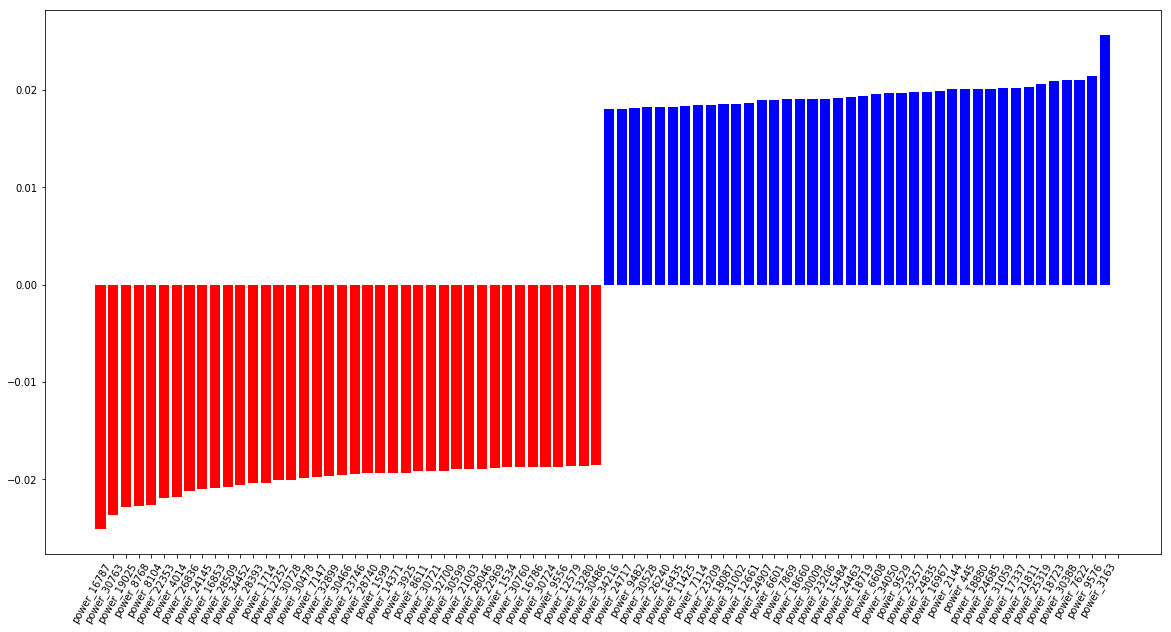

In [59]:
visualize_coefficients(log_reg, feature_names=cols, n_top_features=40)

In [60]:
coef = log_reg.coef_.ravel()

coef.min(), coef.max(), np.abs(coef).min(), len(coef)

(-0.025127487995034403, 0.025645407026400183, 3.0234597564763807e-07, 34716)

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


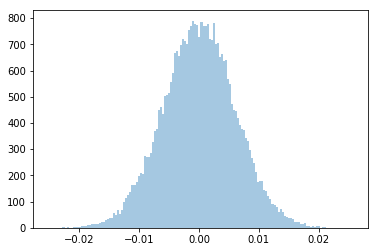

In [61]:
sns.distplot(coef, kde=False, bins=150)

In [62]:
from itertools import product

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import StratifiedKFold


seed = 90
       

class FeatureExtractor(BaseEstimator, TransformerMixin):
        
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        # get only the anatomical information
        return X_df
    

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(
                                StandardScaler(),
                                LogisticRegressionCV(n_jobs=1,
                                                     # cv=StratifiedKFold(n_splits=5, random_state=seed),                                                    
                                                     scoring="roc_auc", 
                                                     random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(
                                 StandardScaler(),
                                 LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

Grid search



In [94]:
neg_thresholds = np.linspace(-0.014, -0.026, 18)
pos_thresholds = np.linspace(0.014, 0.026, 18)

max_features = 350

In [95]:
best_roc = 0.0
best_thresholds = None
max_early_stopping = 100
c = max_early_stopping

for i, (neg_threshold, pos_threshold) in enumerate(product(neg_thresholds, pos_thresholds)):
    print("Trial: ", i, neg_threshold, pos_threshold, end=" | ")
    positive_coefficients = np.where(coef > pos_threshold)[0]
    negative_coefficients = np.where(coef < neg_threshold)[0]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    top_1_selected_columns = np.array(cols)[interesting_coefficients].tolist()
    
    print("{} | ".format(len(top_1_selected_columns)), end=" -> ")
    
    if max_features is not None and len(top_1_selected_columns) > max_features:
        print("NA")
        continue
    
    results = evaluation_with_fixed_test(data2_trainval.loc[:, top_1_selected_columns], 
                                   data2_trainval.loc[:, 'target'].values, 
                                   data2_test.loc[:, top_1_selected_columns], 
                                   data2_test.loc[:, 'target'])
    current_roc = results['mean_validation_roc']
    print(results['mean_validation_roc'], results['mean_test_roc'])        
        
    c -= 1
    if current_roc > best_roc:
        best_thresholds = (neg_threshold, pos_threshold)
        best_roc = current_roc
        c = max_early_stopping

    if c == 0:
        print("Stop by early stopping")
        break

Trial:  0 -0.014 0.014 | 735 |  -> NA
Trial:  1 -0.014 0.014705882352941176 | 639 |  -> NA
Trial:  2 -0.014 0.015411764705882354 | 560 |  -> NA
Trial:  3 -0.014 0.016117647058823528 | 504 |  -> NA
Trial:  4 -0.014 0.016823529411764706 | 456 |  -> NA
Trial:  5 -0.014 0.017529411764705884 | 425 |  -> NA
Trial:  6 -0.014 0.018235294117647058 | 402 |  -> NA
Trial:  7 -0.014 0.018941176470588236 | 394 |  -> NA
Trial:  8 -0.014 0.019647058823529413 | 384 |  -> NA
Trial:  9 -0.014 0.020352941176470588 | 372 |  -> NA
Trial:  10 -0.014 0.021058823529411765 | 369 |  -> NA
Trial:  11 -0.014 0.021764705882352943 | 367 |  -> NA
Trial:  12 -0.014 0.022470588235294117 | 367 |  -> NA
Trial:  13 -0.014 0.02317647058823529 | 367 |  -> NA
Trial:  14 -0.014 0.023882352941176473 | 367 |  -> NA
Trial:  15 -0.014 0.024588235294117647 | 367 |  -> NA
Trial:  16 -0.014 0.02529411764705882 | 367 |  -> NA
Trial:  17 -0.014 0.026 | 366 |  -> NA
Trial:  18 -0.014705882352941176 0.014 | 641 |  -> NA
Trial:  19 -0.01

KeyboardInterrupt: 

In [92]:
# best_thresholds = (-0.0082, 0.0088)
# best_thresholds = (-0.011, 0.011)
# best_thresholds = (-0.010333333333333333, 0.011666666666666665)
# best_thresholds = (-0.02103448275862069, 0.029310344827586206)
best_thresholds

(-0.0175, 0.01525)

In [93]:
# neg_threshold = 0.27 * coef.min()
# pos_threshold = 0.127 * coef.max()
neg_threshold, pos_threshold = best_thresholds
print(neg_threshold, pos_threshold)

positive_coefficients = np.where(coef > pos_threshold)[0]
negative_coefficients = np.where(coef < neg_threshold)[0]

print(len(positive_coefficients), len(negative_coefficients), len(coef))

interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
top_1_selected_columns = np.array(cols)[interesting_coefficients].tolist()


results = evaluation_with_test(data2.loc[:, top_1_selected_columns], 
                               data2.loc[:, 'target'].values)
print(results['avg_mean_validation_roc'], results['avg_mean_test_roc'])        

-0.0175 0.01525
214 81 34716
0.7501439989107432 0.7336448576517722


In [88]:
results

{'trial_0__mean_validation_roc': 0.7883507030446214,
 'trial_0__mean_test_roc': 0.6429432428709189,
 'trial_1__mean_validation_roc': 0.802065974852295,
 'trial_1__mean_test_roc': 0.6198173484269741,
 'trial_2__mean_validation_roc': 0.6812320103014694,
 'trial_2__mean_test_roc': 0.8336950482672408,
 'trial_3__mean_validation_roc': 0.7069004696258142,
 'trial_3__mean_test_roc': 0.8246319188832558,
 'avg_mean_validation_roc': 0.74463728945605,
 'avg_mean_test_roc': 0.7302718896120974,
 'std_mean_validation_roc': 0.05160720257259726,
 'std_mean_test_roc': 0.09928074219142716}